# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
    
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = \
dset.SVHN('/home/artem/Загрузки/dlcourse_ai-master/assignments/assignment1/data', split='train',
         transform=transforms.Compose([
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.43,0.44,0.47],
                                 std=[0.20,0.20,0.20])
         ]))

data_test = \
dset.SVHN('/home/artem/Загрузки/dlcourse_ai-master/assignments/assignment1/data', split='test',
            transform=transforms.Compose([
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.43,0.44,0.47],
                             std=[0.20,0.20,0.20])
            ]))

In [26]:
# data_train.data

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                          sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                        sampler=val_sampler)

In [30]:
train_sampler

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print('SVHN data sample shape: ', sample.shape)

class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [104]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100,10))


# We will minimize cross-entropy between the ground thuth and
# network predictions usinf an SGD optimizer
nn_model.type(torch.FloatTensor)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [7]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x,y) in enumerate(train_loader):
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            
            
            
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        
        scheduler.step()
                                
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" %(ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct_samples = 0
    total_samples = 0
    for i_step, (x,y) in enumerate(loader):
        
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
        
#     raise Exception("Not implemented")
    accuracy = float(correct_samples)/total_samples
    return accuracy

# loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [113]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10)
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.171255, Train accuracy: 0.206702, Val accuracy: 0.243192
Average loss: 2.012766, Train accuracy: 0.271969, Val accuracy: 0.317453
Average loss: 1.809016, Train accuracy: 0.376412, Val accuracy: 0.423111
Average loss: 1.702360, Train accuracy: 0.424035, Val accuracy: 0.445294
Average loss: 1.676991, Train accuracy: 0.436525, Val accuracy: 0.443792


Добавьте слой с Batch Normalization

In [114]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
    Flattener(),
    
    nn.BatchNorm1d(3*32*32),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    
    nn.BatchNorm1d(100),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    
    nn.BatchNorm1d(100),
    nn.Linear(100, 10)
    
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.895051, Train accuracy: 0.395130, Val accuracy: 0.555320
Average loss: 1.517153, Train accuracy: 0.579531, Val accuracy: 0.629104
Average loss: 1.364934, Train accuracy: 0.632614, Val accuracy: 0.671217
Average loss: 1.279191, Train accuracy: 0.658721, Val accuracy: 0.686711
Average loss: 1.225456, Train accuracy: 0.673719, Val accuracy: 0.708825


Добавьте уменьшение скорости обучения по ходу тренировки.

In [112]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
    Flattener(),
    
    nn.BatchNorm1d(3*32*32),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    
    nn.BatchNorm1d(100),
    nn.Linear(100,100),
    nn.ReLU(inplace=True),
    
    nn.BatchNorm1d(100),
    nn.Linear(100,10)
    
    
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

loss_history, train_history, val_history = \
train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 15)

Average loss: 1.908659, Train accuracy: 0.398628, Val accuracy: 0.573817
Average loss: 1.491295, Train accuracy: 0.596850, Val accuracy: 0.656406
Average loss: 1.347636, Train accuracy: 0.644627, Val accuracy: 0.680773
Average loss: 1.288289, Train accuracy: 0.663294, Val accuracy: 0.693058
Average loss: 1.240843, Train accuracy: 0.678275, Val accuracy: 0.710327
Average loss: 1.219859, Train accuracy: 0.685817, Val accuracy: 0.714559
Average loss: 1.197503, Train accuracy: 0.692574, Val accuracy: 0.718995
Average loss: 1.188392, Train accuracy: 0.693274, Val accuracy: 0.722545
Average loss: 1.176736, Train accuracy: 0.698034, Val accuracy: 0.726367
Average loss: 1.172264, Train accuracy: 0.697744, Val accuracy: 0.728824
Average loss: 1.166121, Train accuracy: 0.702522, Val accuracy: 0.726026
Average loss: 1.161712, Train accuracy: 0.703938, Val accuracy: 0.728960
Average loss: 1.160286, Train accuracy: 0.704058, Val accuracy: 0.732851
Average loss: 1.159945, Train accuracy: 0.705354, V

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [10]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)


In [55]:
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labelsmodel.eval()
    # Hint: SubsetSampler above could be useful!
    
    
    
    ground_truth = np.array(dataset.labels[indices], np.int64)
    
    model.eval() # Evaluation mode
    
    predictions = np.array([], np.int64)
    
    sampler = SubsetSampler(indices)
        
    
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                        sampler=sampler)
    
    for i_step, (x,y) in enumerate(loader):
        prediction = np.argmax(model(x).detach().numpy(), axis=1)

        predictions = np.concatenate((predictions, prediction))

    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)

In [64]:
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

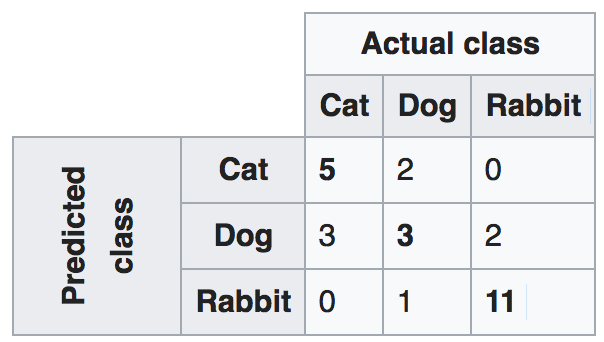

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

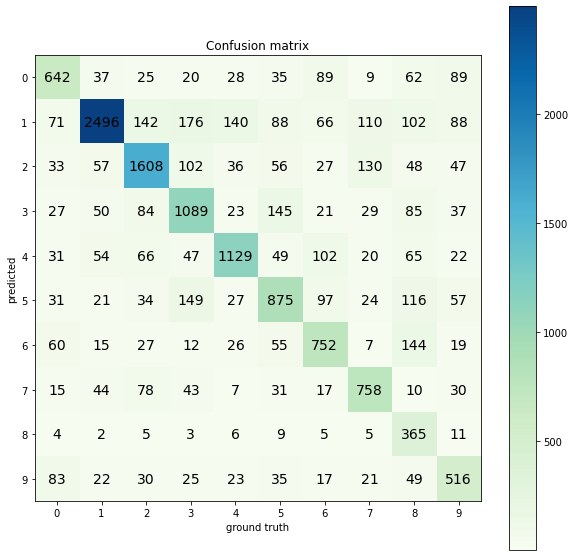

In [69]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    for i in range(10):
        for j in range(10):
            
            counter = 0
#             predictions, gt
            for ind in range(len(gt)):
                if gt[ind] == j and predictions[ind] == i:
                    counter += 1
            
            confusion_matrix[i][j] = counter
    
    # TODO: Implement filling the prediction matrix
#     return np.array([[40, 2, 3], [10, 50,0], [0, 2, 80]])
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

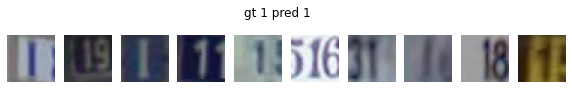

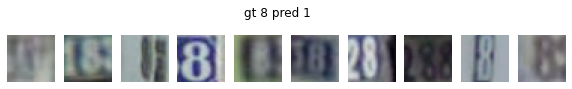

In [110]:
data_train_images = \
    dset.SVHN('/home/artem/Загрузки/dlcourse_ai-master/assignments/assignment1/data', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
#     raise Exception("Not implemented")
    indices = []
    
#     LEN = len(groud_truth)
    
#     for ind in range(LEN):

#         if predictions[ind] == predicted_class and groud_truth[ind] == gt_class:
            
#             indices.append(val_indices[ind])
                
#     mask = np.arange()
#     mask = (predictions == predicted_class) and (groud_truth == gt_class)
    

    
    mask_1 = (predictions == predicted_class) * 1
    mask_2 = (groud_truth == gt_class) * 1
#     print(mask_1)
#     print()
#     print(mask_2)
#     print()
#     print(mask_1 * mask_2)
    mask_ = (mask_1 * mask_2).astype(bool)
    
    indices = val_indices[mask_]
    
    title = 'gt ' + str(gt_class) + ' pred ' + str(predicted_class)
    
    visualize_images(indices, data, title=title, max_num=10)
    
    
visualize_predicted_actual(1, 1, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 8, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!


Точность на тестовой выборке должна быть доведена до **80%**

In [123]:

    
    
         
lr_batch = [1e-1, 1e-2, 1e-3, 1e-4]
wd_batch = [1e-1, 1e-2, 1e-3]
ss_batch = [1,2,3]

max_val_result = 0

for lr in lr_batch:
    for wd in wd_batch:
        for ss in ss_batch:
            
            nn_model = nn.Sequential(
            Flattener(),

            nn.BatchNorm1d(3*32*32),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),

            nn.BatchNorm1d(100),
            nn.Linear(100,100),
            nn.ReLU(inplace=True),

            nn.BatchNorm1d(100),
            nn.Linear(100,10)
            )

            print('learning_rate = ' + str(lr))
            print('weight_decay = ' + str(wd))
            print('step_size = ' + str(ss))

            optimizer = optim.SGD(nn_model.parameters(), lr=lr, weight_decay=wd)

            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=ss, gamma=0.5)

            loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

            loss_history, train_history, val_history = \
            train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 15)

            val_result = val_history.pop()

            if max_val_result < val_result:
                max_val_result = val_result
                best_nn_model = nn_model
                print('BEST_VAL_RESULT = ', str(max_val_result))

learning_rate = 0.1
weight_decay = 0.1
step_size = 1
Average loss: 1.999305, Train accuracy: 0.337935, Val accuracy: 0.312607
Average loss: 1.928989, Train accuracy: 0.371873, Val accuracy: 0.365641
Average loss: 1.850397, Train accuracy: 0.403355, Val accuracy: 0.322777
Average loss: 1.775149, Train accuracy: 0.438982, Val accuracy: 0.375264
Average loss: 1.722116, Train accuracy: 0.464031, Val accuracy: 0.474234
Average loss: 1.683325, Train accuracy: 0.482664, Val accuracy: 0.492458
Average loss: 1.653595, Train accuracy: 0.498481, Val accuracy: 0.513617
Average loss: 1.636276, Train accuracy: 0.504317, Val accuracy: 0.513003
Average loss: 1.625240, Train accuracy: 0.506791, Val accuracy: 0.525630
Average loss: 1.618582, Train accuracy: 0.513070, Val accuracy: 0.527882
Average loss: 1.615630, Train accuracy: 0.513514, Val accuracy: 0.527814
Average loss: 1.613953, Train accuracy: 0.516483, Val accuracy: 0.535595
Average loss: 1.613227, Train accuracy: 0.514913, Val accuracy: 0.53129

Average loss: 1.340212, Train accuracy: 0.559209, Val accuracy: 0.672446
Average loss: 0.970803, Train accuracy: 0.693001, Val accuracy: 0.752645
Average loss: 0.790701, Train accuracy: 0.752995, Val accuracy: 0.784656
Average loss: 0.745369, Train accuracy: 0.766082, Val accuracy: 0.787796
Average loss: 0.665311, Train accuracy: 0.793451, Val accuracy: 0.809911
Average loss: 0.645231, Train accuracy: 0.800072, Val accuracy: 0.819466
Average loss: 0.603817, Train accuracy: 0.811436, Val accuracy: 0.826019
Average loss: 0.590025, Train accuracy: 0.817305, Val accuracy: 0.831684
Average loss: 0.563511, Train accuracy: 0.825803, Val accuracy: 0.835506
Average loss: 0.557348, Train accuracy: 0.827509, Val accuracy: 0.835301
Average loss: 0.545739, Train accuracy: 0.831178, Val accuracy: 0.837485
Average loss: 0.536478, Train accuracy: 0.834761, Val accuracy: 0.837690
Average loss: 0.527620, Train accuracy: 0.838276, Val accuracy: 0.838100
Average loss: 0.526391, Train accuracy: 0.838259, V

KeyboardInterrupt: 

In [126]:



nn_model = nn.Sequential(
    Flattener(),

    nn.BatchNorm1d(3*32*32),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),

    nn.BatchNorm1d(100),
    nn.Linear(100,100),
    nn.ReLU(inplace=True),

    nn.BatchNorm1d(100),
    nn.Linear(100,10)
)


optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-2)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

loss_history, train_history, val_history = \
train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 15)

     

Average loss: 1.379148, Train accuracy: 0.550882, Val accuracy: 0.650672
Average loss: 1.110904, Train accuracy: 0.651640, Val accuracy: 0.688281
Average loss: 0.931109, Train accuracy: 0.715729, Val accuracy: 0.742680
Average loss: 0.896299, Train accuracy: 0.725062, Val accuracy: 0.754897
Average loss: 0.776334, Train accuracy: 0.764905, Val accuracy: 0.765886
Average loss: 0.771621, Train accuracy: 0.765399, Val accuracy: 0.789025
Average loss: 0.691292, Train accuracy: 0.793536, Val accuracy: 0.823698
Average loss: 0.684841, Train accuracy: 0.795823, Val accuracy: 0.806976
Average loss: 0.627961, Train accuracy: 0.816452, Val accuracy: 0.832298
Average loss: 0.619596, Train accuracy: 0.817015, Val accuracy: 0.847860
Average loss: 0.581857, Train accuracy: 0.830342, Val accuracy: 0.851000
Average loss: 0.577492, Train accuracy: 0.831587, Val accuracy: 0.851955
Average loss: 0.551706, Train accuracy: 0.839624, Val accuracy: 0.856597
Average loss: 0.549005, Train accuracy: 0.841211, V

In [239]:
learning_rate = 0.11961580513907547
weight_decay = 7.913375982950319e-05
batch_size = 64

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                              sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                            sampler=val_sampler)



nn_model = nn.Sequential(
    Flattener(),

    nn.BatchNorm1d(3*32*32),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),

    nn.BatchNorm1d(100),
    nn.Linear(100,100),
    nn.ReLU(inplace=True),

    nn.BatchNorm1d(100),
    nn.Linear(100,10)
)


optimizer = optim.SGD(nn_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

loss_history, train_history, val_history = \
train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 15)

     

Average loss: 1.330506, Train accuracy: 0.563816, Val accuracy: 0.686028
Average loss: 0.959567, Train accuracy: 0.696601, Val accuracy: 0.754556
Average loss: 0.774509, Train accuracy: 0.758387, Val accuracy: 0.783701
Average loss: 0.729912, Train accuracy: 0.774050, Val accuracy: 0.786772
Average loss: 0.654713, Train accuracy: 0.797461, Val accuracy: 0.814484
Average loss: 0.639947, Train accuracy: 0.800515, Val accuracy: 0.823425
Average loss: 0.595609, Train accuracy: 0.814592, Val accuracy: 0.828476
Average loss: 0.581794, Train accuracy: 0.821179, Val accuracy: 0.826565
Average loss: 0.561426, Train accuracy: 0.826485, Val accuracy: 0.835779
Average loss: 0.553142, Train accuracy: 0.828209, Val accuracy: 0.833936
Average loss: 0.546961, Train accuracy: 0.830700, Val accuracy: 0.838441
Average loss: 0.539076, Train accuracy: 0.833635, Val accuracy: 0.839397
Average loss: 0.536332, Train accuracy: 0.834522, Val accuracy: 0.839738
Average loss: 0.532879, Train accuracy: 0.835239, V

In [245]:
variants = []

NUM_BATCHES = 3
NUM_W_D = 3
NUM_BATCH_S = 3

lr_mean = 1e-1
weight_decay_mean = 1e-2
batch_size_mean = 64

for i in range(NUM_BATCHES * NUM_W_D * NUM_BATCH_S):
    
    lr = lr_mean + 0.1 * np.random.rand()
    weight_decay = weight_decay_mean * 0.01 * np.random.rand()
    batch_size = 2 ** np.random.randint(6,8)
    
    variants.append([lr, weight_decay, batch_size])
    
    
variants

[[0.1453250790722146, 8.200494104627245e-05, 128],
 [0.1360315233892068, 9.538757867213313e-05, 128],
 [0.11122911720933124, 4.9893471735825334e-05, 64],
 [0.1981705946416764, 1.0527997021897696e-05, 128],
 [0.19956597419556865, 2.6146005891534354e-05, 64],
 [0.10887989930329343, 3.863948888798594e-05, 64],
 [0.18767608642382916, 2.4751803921071003e-05, 64],
 [0.11330369416210816, 4.5707262817327154e-05, 64],
 [0.19768916263439978, 6.727883969947114e-05, 64],
 [0.1734785455336068, 6.0471719226576974e-05, 128],
 [0.13530387777155856, 2.599264071636449e-05, 64],
 [0.11833022646993696, 8.655150863099333e-05, 64],
 [0.15423026198323547, 4.129805931931379e-05, 128],
 [0.1240147262083307, 1.2963187010186728e-06, 128],
 [0.16514818483859042, 3.9048185740448165e-05, 64],
 [0.13330938696890343, 3.912783813036469e-05, 128],
 [0.13552234242024902, 2.4292185211093753e-05, 64],
 [0.12972703289217272, 3.365396630313775e-05, 64],
 [0.16819606092729095, 5.793894310822533e-05, 64],
 [0.1228753161682502

In [250]:
max_val_result = 0
step_size = 2

for variant in variants:
    lr = variant[0]
    weight_decay = variant[1]
    batch_size = variant[2]
    

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                  sampler=train_sampler)

    val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                sampler=val_sampler)

    nn_model = nn.Sequential(
    Flattener(),

    nn.BatchNorm1d(3*32*32),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),

    nn.BatchNorm1d(100),
    nn.Linear(100,100),
    nn.ReLU(inplace=True),

    nn.BatchNorm1d(100),
    nn.Linear(100,10)
    )

    print('learning_rate = ' + str(lr))
    print('weight_decay = ' + str(wd))
    print('batch_size = ' + str(batch_size))

    optimizer = optim.Adam(nn_model.parameters(), lr=lr, weight_decay=wd)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)

    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

    loss_history, train_history, val_history = \
    train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, 15)

    val_result = val_history.pop()

    if max_val_result < val_result:
        max_val_result = val_result
        best_nn_model = nn_model
        print('BEST_VAL_RESULT = ', str(max_val_result))
# 10 100 100 10
# BEST_VAL_RESULT =  0.840556958569381
# test 0.8094

learning_rate = 0.1453250790722146
weight_decay = 7.913375982950319e-05
batch_size = 128
Average loss: 1.807125, Train accuracy: 0.401802, Val accuracy: 0.487680
Average loss: 1.534080, Train accuracy: 0.511927, Val accuracy: 0.517098
Average loss: 1.225326, Train accuracy: 0.617582, Val accuracy: 0.635042
Average loss: 1.187221, Train accuracy: 0.633399, Val accuracy: 0.626920
Average loss: 1.052303, Train accuracy: 0.674214, Val accuracy: 0.698655
Average loss: 1.036474, Train accuracy: 0.681210, Val accuracy: 0.687530
Average loss: 0.940920, Train accuracy: 0.711770, Val accuracy: 0.728551
Average loss: 0.926663, Train accuracy: 0.715029, Val accuracy: 0.740154
Average loss: 0.859962, Train accuracy: 0.737808, Val accuracy: 0.756058
Average loss: 0.843125, Train accuracy: 0.741238, Val accuracy: 0.763634
Average loss: 0.801952, Train accuracy: 0.756339, Val accuracy: 0.776739
Average loss: 0.790982, Train accuracy: 0.759769, Val accuracy: 0.781448
Average loss: 0.768633, Train accur

Average loss: 0.818437, Train accuracy: 0.751186, Val accuracy: 0.789844
Average loss: 0.787625, Train accuracy: 0.759461, Val accuracy: 0.798649
BEST_VAL_RESULT =  0.7986485564125315
learning_rate = 0.11330369416210816
weight_decay = 7.913375982950319e-05
batch_size = 64
Average loss: 1.985430, Train accuracy: 0.331161, Val accuracy: 0.410279
Average loss: 1.673398, Train accuracy: 0.454715, Val accuracy: 0.379769
Average loss: 1.369264, Train accuracy: 0.558680, Val accuracy: 0.545424
Average loss: 1.332347, Train accuracy: 0.575692, Val accuracy: 0.591291
Average loss: 1.162242, Train accuracy: 0.636266, Val accuracy: 0.659887
Average loss: 1.140289, Train accuracy: 0.644081, Val accuracy: 0.632244
Average loss: 1.051475, Train accuracy: 0.672542, Val accuracy: 0.707392
Average loss: 1.032763, Train accuracy: 0.678565, Val accuracy: 0.709440
Average loss: 0.973093, Train accuracy: 0.697761, Val accuracy: 0.739949
Average loss: 0.959004, Train accuracy: 0.701856, Val accuracy: 0.7393

Average loss: 0.770999, Train accuracy: 0.768624, Val accuracy: 0.790799
Average loss: 0.743141, Train accuracy: 0.778760, Val accuracy: 0.796874
Average loss: 0.730339, Train accuracy: 0.781678, Val accuracy: 0.796737
Average loss: 0.713984, Train accuracy: 0.786097, Val accuracy: 0.801242
learning_rate = 0.16514818483859042
weight_decay = 7.913375982950319e-05
batch_size = 64
Average loss: 2.131668, Train accuracy: 0.302307, Val accuracy: 0.412259
Average loss: 2.111962, Train accuracy: 0.296011, Val accuracy: 0.326940
Average loss: 1.613055, Train accuracy: 0.458366, Val accuracy: 0.513958
Average loss: 1.513539, Train accuracy: 0.512849, Val accuracy: 0.504061
Average loss: 1.268227, Train accuracy: 0.601645, Val accuracy: 0.595932
Average loss: 1.232304, Train accuracy: 0.615347, Val accuracy: 0.630537
Average loss: 1.094679, Train accuracy: 0.660086, Val accuracy: 0.693400
Average loss: 1.071369, Train accuracy: 0.665768, Val accuracy: 0.697154
Average loss: 0.982276, Train accur

Average loss: 0.808654, Train accuracy: 0.752414, Val accuracy: 0.774964
Average loss: 0.791605, Train accuracy: 0.757346, Val accuracy: 0.778991
Average loss: 0.764016, Train accuracy: 0.768454, Val accuracy: 0.787728
Average loss: 0.756728, Train accuracy: 0.771064, Val accuracy: 0.787045
Average loss: 0.741538, Train accuracy: 0.774050, Val accuracy: 0.793188
learning_rate = 0.11060972449067044
weight_decay = 7.913375982950319e-05
batch_size = 64
Average loss: 1.935492, Train accuracy: 0.350851, Val accuracy: 0.445635
Average loss: 1.788588, Train accuracy: 0.404378, Val accuracy: 0.338885
Average loss: 1.487368, Train accuracy: 0.509180, Val accuracy: 0.535390
Average loss: 1.383816, Train accuracy: 0.557469, Val accuracy: 0.606580
Average loss: 1.164262, Train accuracy: 0.637017, Val accuracy: 0.681114
Average loss: 1.139040, Train accuracy: 0.644780, Val accuracy: 0.657566
Average loss: 1.013181, Train accuracy: 0.684845, Val accuracy: 0.721657
Average loss: 0.978954, Train accur

In [249]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(best_nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8036
